<a target="_blank" href="https://colab.research.google.com/github/cohere-ai/notebooks/blob/main/notebooks/What_Is_Similarity_Between_Sentences.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Similarity Between Words and Sentences

Sentence embeddings are the bread and butter of language models, as they associate each sentence with a particular list of numbers (a vector), in a way that similar sentences give similar vectors. We can think of embeddings as a way to locate each sentence in space (a high dimensional space, but a space nonetheless), in a way that similar sentences are located close by. Once we have each sentence somewhere in space, it’s natural to think of distances between them. And an even more intuitive way to think of distances is to think of similarities, i.e., a score assigned to each pair of sentences, which is high when these sentences are similar, and low when they are different. The similarity is a very useful concept in large language models, as it can be used for search, for translation, for summarization, and in many other applications.

In this notebook, we understand the intuition behind similarities between sentences, including dot product and cosine similarity.

_Read the accompanying [blog post here](https://docs.cohere.com/docs/similarity-between-words-and-sentences)._

## Overview

We'll do the following steps:
- **Step 1: Turn Text into Embeddings** - Use Cohere's Embed endpoint to get sentence embeddings.
- **Step 2: Calculate Dot Products** - Calculate the dot products between each pair of sentence embeddings to understand similarity between them.
- **Step 3: Calculate Cosine Similarities** - Use scikit-learn to get the cosine similarity for each pair of sentence embeddings.

## Setup

We'll start by installing the tools we'll need and then importing them.

In [1]:
! pip install cohere -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00


In [2]:
import cohere
import numpy as np
import seaborn as sns
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity

Fill in your Cohere API key in the next cell. To do this, begin by [signing up to Cohere](https://os.cohere.ai/) (for free!) if you haven't yet. Then get your API key [here](https://dashboard.cohere.com/api-keys).

In [3]:
# Paste your API key here. Remember to not share publicly
co = cohere.Client("kppLsqOZUX7HIkv3IiE0aITqkwo7hXzCb7YSggfO")

## Step 1: Turn Text into Embeddings

In this notebook, we'll work with three sentences and store them in a Python list `texts`.

In [4]:
texts = ["I like to be in my house",
         "I enjoy staying home",
         "the isotope 238u decays to 206pb"]

To get the corresponding sentence embeddings, we call the [Embed endpoint](https://docs.cohere.com/reference/embed) with `co.embed()`. We supply three parameters:
- `texts` - our list of sentences
- `model` - we use `embed-english-v3.0`, Cohere's latest (at the time of writing) English-only embeddings model to generate the embeddings
- `input_type` - we use `search_document` to indicate that we intend to use the embeddings for search use-cases

You'll learn about these parameters in more detail in the [LLMU Module on Text Representation](https://docs.cohere.com/docs/intro-text-representation).

In [5]:
response = co.embed(
    texts=texts,
    model='embed-english-v3.0',
    input_type='search_document'
)

The embeddings are stored in the `embeddings` value of the response. After getting the embeddings, we separate them by sentence.

In [6]:
embeddings = response.embeddings

[sentence1, sentence2, sentence3] = embeddings

print("Embedding for sentence 1", np.array(sentence1))
print("Embedding for sentence 2", np.array(sentence2))
print("Embedding for sentence 3", np.array(sentence3))

Embedding for sentence 1 [ 0.05075073  0.03753662 -0.02958679 ... -0.07366943 -0.00842285
 -0.01834106]
Embedding for sentence 2 [ 0.04333496  0.05407715 -0.02453613 ... -0.06182861 -0.01983643
 -0.0096283 ]
Embedding for sentence 3 [ 0.02383423  0.00695801 -0.04669189 ... -0.04006958 -0.02304077
  0.01963806]


Note that the embeddings are vectors (lists) of 1024 numbers, so they are truncated here (thus the dots in between).  One would expect that the vectors corresponding to sentences 1 and 2 are similar to each other and that both are different from the vector corresponding to sentence 3. However, from inspection, this is not very clear. We need to calculate some similarities to see if this is the case.  We will do that in the following two sections.

## Step 2: Calculate Dot Products

Let’s calculate the dot products between the three sentences to understand how similar they are to each other.

In [7]:
print("Similarity between sentences 1 and 2:", np.dot(sentence1, sentence2))
print("Similarity between sentences 1 and 3:", np.dot(sentence1, sentence3))
print("Similarity between sentences 2 and 3:", np.dot(sentence2, sentence3))

Similarity between sentences 1 and 2: 0.8187172323456495
Similarity between sentences 1 and 3: 0.1952170633623921
Similarity between sentences 2 and 3: 0.19826654576138197


The similarity between sentences 1 and 2 (0.8188) is much larger than the similarities between the other pairs. This confirms our predictions.

Just for consistency, let’s calculate the similarities between each sentence and itself, to confirm that a sentence and itself has the highest similarity score.

In [8]:
print("Similarity between sentences 1 and 1:", np.dot(sentence1, sentence1))
print("Similarity between sentences 2 and 2:", np.dot(sentence2, sentence2))
print("Similarity between sentences 3 and 3:", np.dot(sentence3, sentence3))

Similarity between sentences 1 and 1: 1.0001818411403134
Similarity between sentences 2 and 2: 0.9997857473557472
Similarity between sentences 3 and 3: 0.9998230785105998


This checks out—the similarity between a sentence and itself is around 1, which is higher than all the other similarities.

## Step 3: Calculate Cosine Similarities

We use the `cosine_similarity()` function from scikit-learn to measure cosine similarity between the three sentences.

In [9]:
print("Cosine similarity between sentences 1 and 2:", cosine_similarity([sentence1], [sentence2])[0][0])
print("Cosine similarity between sentences 1 and 3:", cosine_similarity([sentence1], [sentence3])[0][0])
print("Cosine similarity between sentences 2 and 3:", cosine_similarity([sentence2], [sentence3])[0][0])

Cosine similarity between sentences 1 and 2: 0.8187305165459494
Cosine similarity between sentences 1 and 3: 0.195216586304462
Cosine similarity between sentences 2 and 3: 0.1983053317541077


Now let’s check the similarity between each sentence and itself.

In [10]:
print("Cosine similarity between sentences 1 and 1:", cosine_similarity([sentence1], [sentence1])[0][0])
print("Cosine similarity between sentences 2 and 2:", cosine_similarity([sentence2], [sentence2])[0][0])
print("Cosine similarity between sentences 3 and 3:", cosine_similarity([sentence3], [sentence3])[0][0])

Cosine similarity between sentences 1 and 1: 1.0000000000000007
Cosine similarity between sentences 2 and 2: 0.9999999999999999
Cosine similarity between sentences 3 and 3: 0.9999999999999999


We also plot the results in a grid.

[Text(0.5, 0, 'I like to be in my house'),
 Text(1.5, 0, 'I enjoy staying home'),
 Text(2.5, 0, 'the isotope 238u decays to 206pb')]

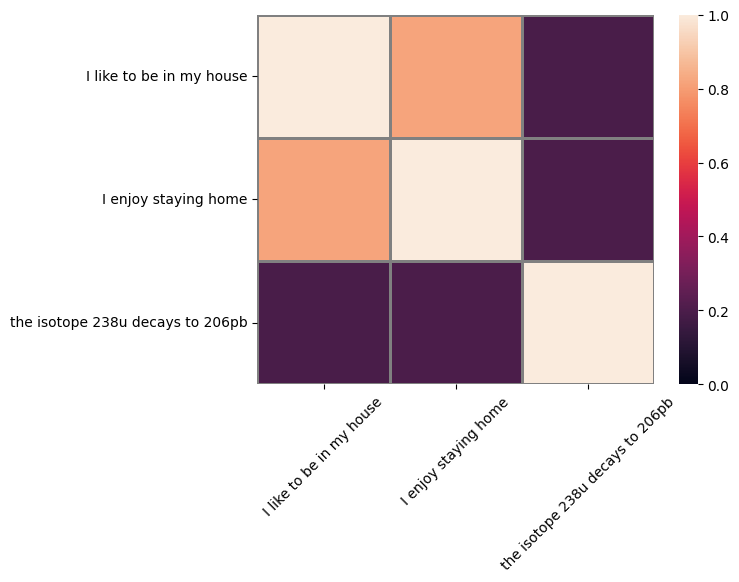

In [11]:
# Get pairwise dot product similarities
dot_product_similarities = [[cosine_similarity([embeddings[i]], [embeddings[j]])[0][0] for i in range(len(embeddings))] for j in range(len(embeddings))]

# Plot in 3x3 grid
ax = sns.heatmap(dot_product_similarities, vmin=0, vmax=1,
                 linewidths=1, linecolor='grey',
                 xticklabels=texts,
                 yticklabels=texts,
)
ax.set_xticklabels(labels=texts, rotation=45)

Notice that the dot product and cosine distance give nearly identical values. The reason for this is that the embedding is normalized (meaning each vector has norm equal to 1). When the embedding is not normalized, the dot product and cosine distance would give different values.

In [12]:
import cohere
co = cohere.Client('kppLsqOZUX7HIkv3IiE0aITqkwo7hXzCb7YSggfO') # This is your trial API key

response = co.embed(
  model='embed-english-v3.0',
  texts=["I like my dog", "I love my dog", "I adore my dog", "Hello, how are you?", "Hey, how\'s it going?", "Hi, what\'s up?", "I love watching soccer", "I enjoyed watching the world cup", "I like watching soccer matches"],
  input_type='classification',
  truncate='NONE'
)

print('Embeddings: {}'.format(response.embeddings))

Embeddings: [[0.0021476746, 0.02470398, -0.04660034, 0.00566864, -0.024978638, -0.031234741, -0.02456665, -0.021469116, 0.026290894, 0.0028858185, -0.022827148, -0.016494751, -0.010734558, -0.023101807, -0.0011949539, -0.04638672, -0.016723633, 0.07171631, 0.023834229, -0.0053367615, 0.0039901733, -0.0129776, -0.032318115, -0.055786133, 0.06161499, 0.007598877, -0.0012407303, -0.039276123, 0.007858276, -0.034332275, 0.010353088, 0.040740967, 0.015792847, 0.029632568, -0.02947998, 0.04321289, 0.007858276, -0.008529663, -0.01789856, 0.008926392, 0.016326904, 0.003572464, -0.025161743, -0.014678955, -0.036834717, -0.040618896, 0.022018433, -0.016281128, 0.044403076, -0.034698486, 0.02166748, 0.061950684, 0.022506714, -0.05001831, -0.025619507, 0.016555786, -0.011253357, -0.011459351, 0.052368164, -0.06951904, -0.030166626, -0.055633545, 0.070129395, 0.05682373, -0.021194458, -0.011764526, -0.0715332, 0.0143585205, -0.034240723, -0.023910522, 0.023284912, -0.04901123, 0.025970459, -0.06518

In [19]:
import cohere

co = cohere.Client("kppLsqOZUX7HIkv3IiE0aITqkwo7hXzCb7YSggfO")

response = co.chat(
	message="how to know whether the integral of a function can be written in elementary functions or not?"
)

print(response)


text='Determining whether the integral of a function can be expressed in terms of elementary functions is a fundamental problem in calculus and mathematical analysis, but it is not always straightforward. The process involves a combination of mathematical techniques, theorems, and sometimes, complex analysis. Here are some approaches to tackle this problem:\n\n- **Differential Galois Theory:** This theory provides a systematic way to determine if a given function has an elementary antiderivative. The idea is to consider the field of rational functions and their derivatives. If the function you are integrating extends this field in such a way that it becomes algebraically closed, then the integral cannot be expressed in elementary form. Liouville\'s Theorem and the Risch Algorithm are based on this theory.\n\n- **Liouville\'s Theorem:** This theorem states that for an elementary function to have an elementary antiderivative, it must satisfy certain conditions. If a function fails to mee